一、数据说明： Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的共享单车数据。数据包含每天的日期、天气等信息，需要预测每天的共享单车骑行量。
解题提示
原始数据集地址：http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

1) 文件说明
day.csv: 按天计的单车共享次数（作业只需使用该文件）
hour.csv: 按小时计的单车共享次数（无需理会）
readme：数据说明文件

2) 字段说明
Instant记录号
Dteday：日期
Season：季节（1=春天、2=夏天、3=秋天、4=冬天）
yr：年份，(0: 2011, 1:2012)
mnth：月份( 1 to 12)
hr：小时 (0 to 23) （只在hour.csv有，作业忽略此字段）
holiday：是否是节假日（0/1）
weekday：星期中的哪天，取值为0～6
workingday：是否工作日（0/1）
1=工作日 （是否为工作日，1为工作日，0为非周末或节假日）
weathersit：天气（1：晴天，多云 2：雾天，阴天 3：小雪，小雨 4：大雨，大雪，大雾）
temp：气温摄氏度
atemp：体感温度
hum：湿度
windspeed：风速
casual：非注册用户贡献的骑行量（作业无需理会该字段）
registered：注册用户贡献的骑行量（作业无需理会该字段）
cnt：给定日期（天, day.csv）时间（每小时,hour.csv）总租车人数，响应变量y

casual、registered和cnt三个特征均为要预测的y（cnt =casual+registered ），作业里只需对cnt进行预测。

## 导入必要的工具包

In [4]:
# 数据读取及基本处理
import numpy as np
import pandas as pd

#可视化
import matplotlib.pyplot as plt
import seaborn as sns

#时间特征处理
import time
import datetime

#线性模型
from sklearn.linear_model import LinearRegression, RidgeCV,LassoCV,ElasticNetCV

#模型评估
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

## 读取数据

In [5]:
# 读取数据
data = pd.read_csv("day.csv")

In [6]:
#数据信息
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011/1/1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011/1/2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011/1/3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011/1/4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011/1/5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 数值型特征

In [7]:
# 常用统计量观察其分布
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000229AF29AB70>,
      dtype=object)

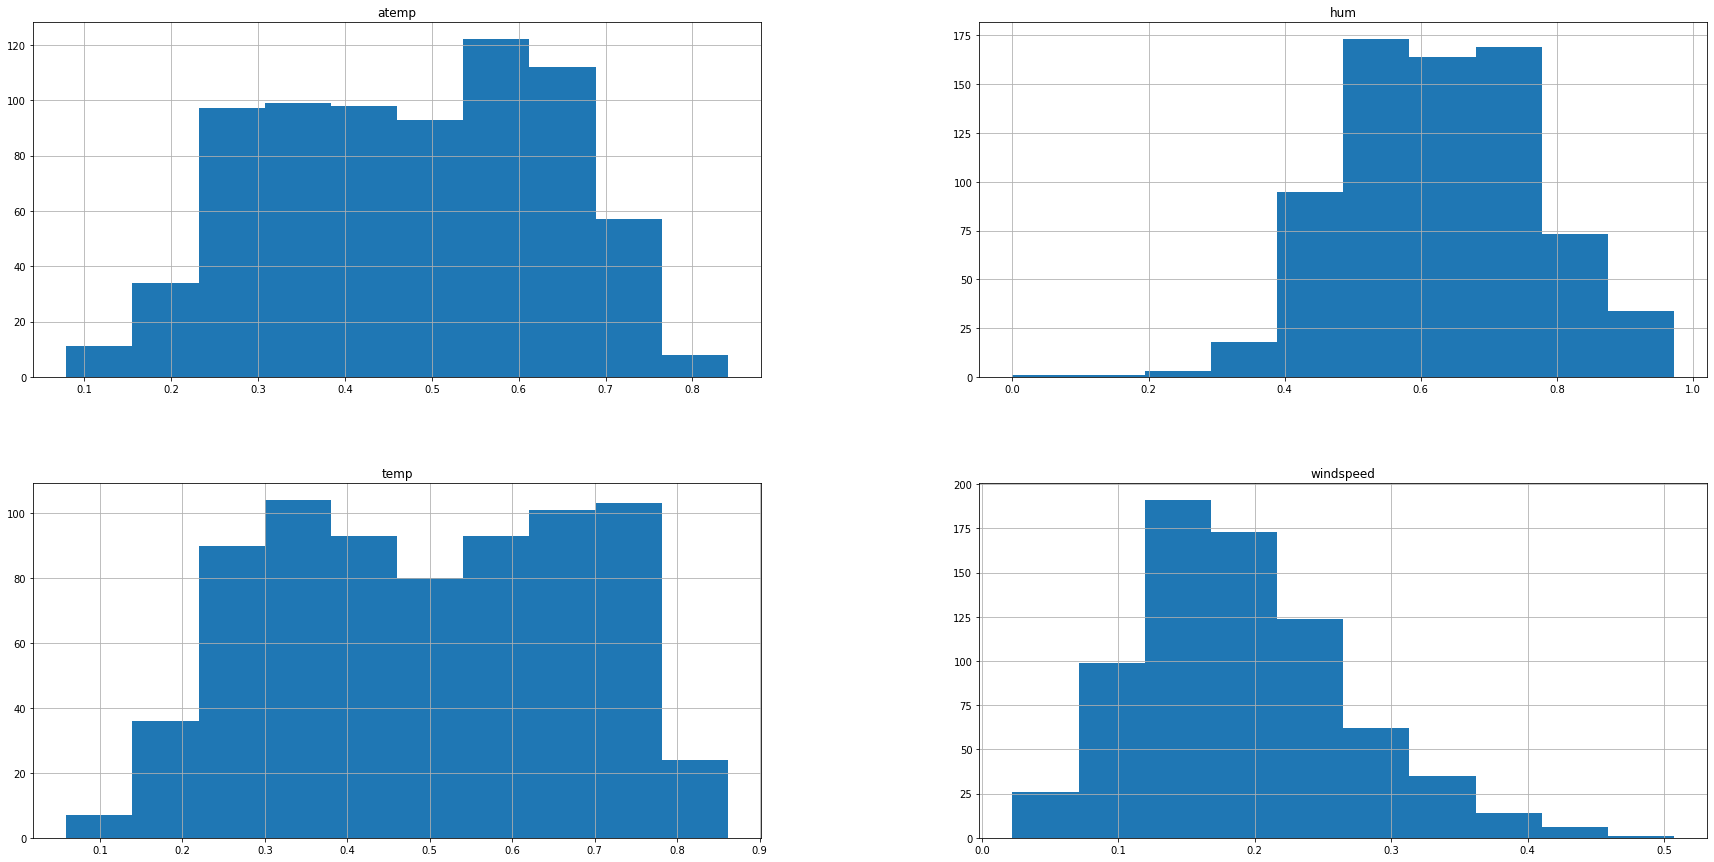

In [8]:
#直方图分布
numerical_features = ['temp', 'atemp', 'hum', 'windspeed']
data[numerical_features].hist(figsize=(30,15))

## 类别特征

In [32]:
# 对于类别特征，观察其取值范围及直方图
categorical_features=['season','mnth','weathersit','weekday']
for col in categorical_features:
    print('\n%s属性的不同取值和出现的次数'%col)
    print(data[col].value_counts())
    data[col]=data[col].astype('object')


season属性的不同取值和出现的次数
3    188
2    184
1    181
4    178
Name: season, dtype: int64

mnth属性的不同取值和出现的次数
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64

weathersit属性的不同取值和出现的次数
1    463
2    247
3     21
Name: weathersit, dtype: int64

weekday属性的不同取值和出现的次数
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64


类别型特征的取值不多，类别型特征可以采用独热编码（One hot encoding）/哑编码

## 特征与目标之间的关系

### 每年骑行量的分布

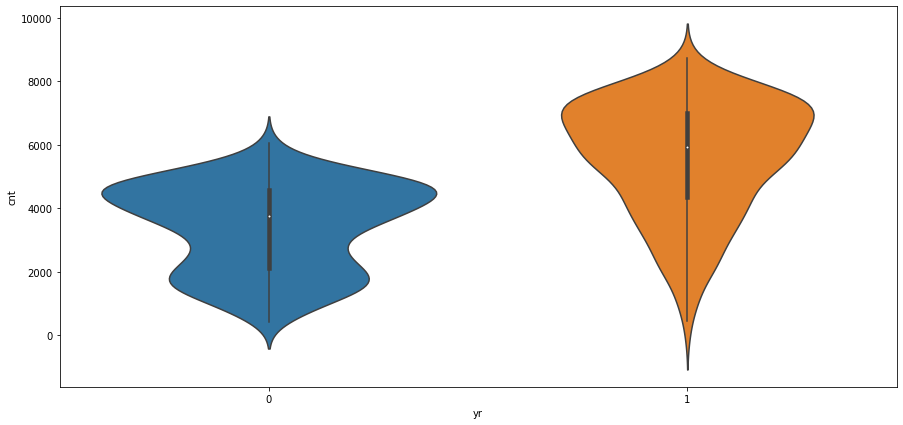

In [15]:
# violinplot中用x表示类别（年）信息

fig,ax=plt.subplots(figsize=(15,7))
sns.violinplot(data=data[['yr','cnt']],x='yr',y='cnt')

2011年骑行量和2012年分布差异很大

### 每季度骑行量的分布

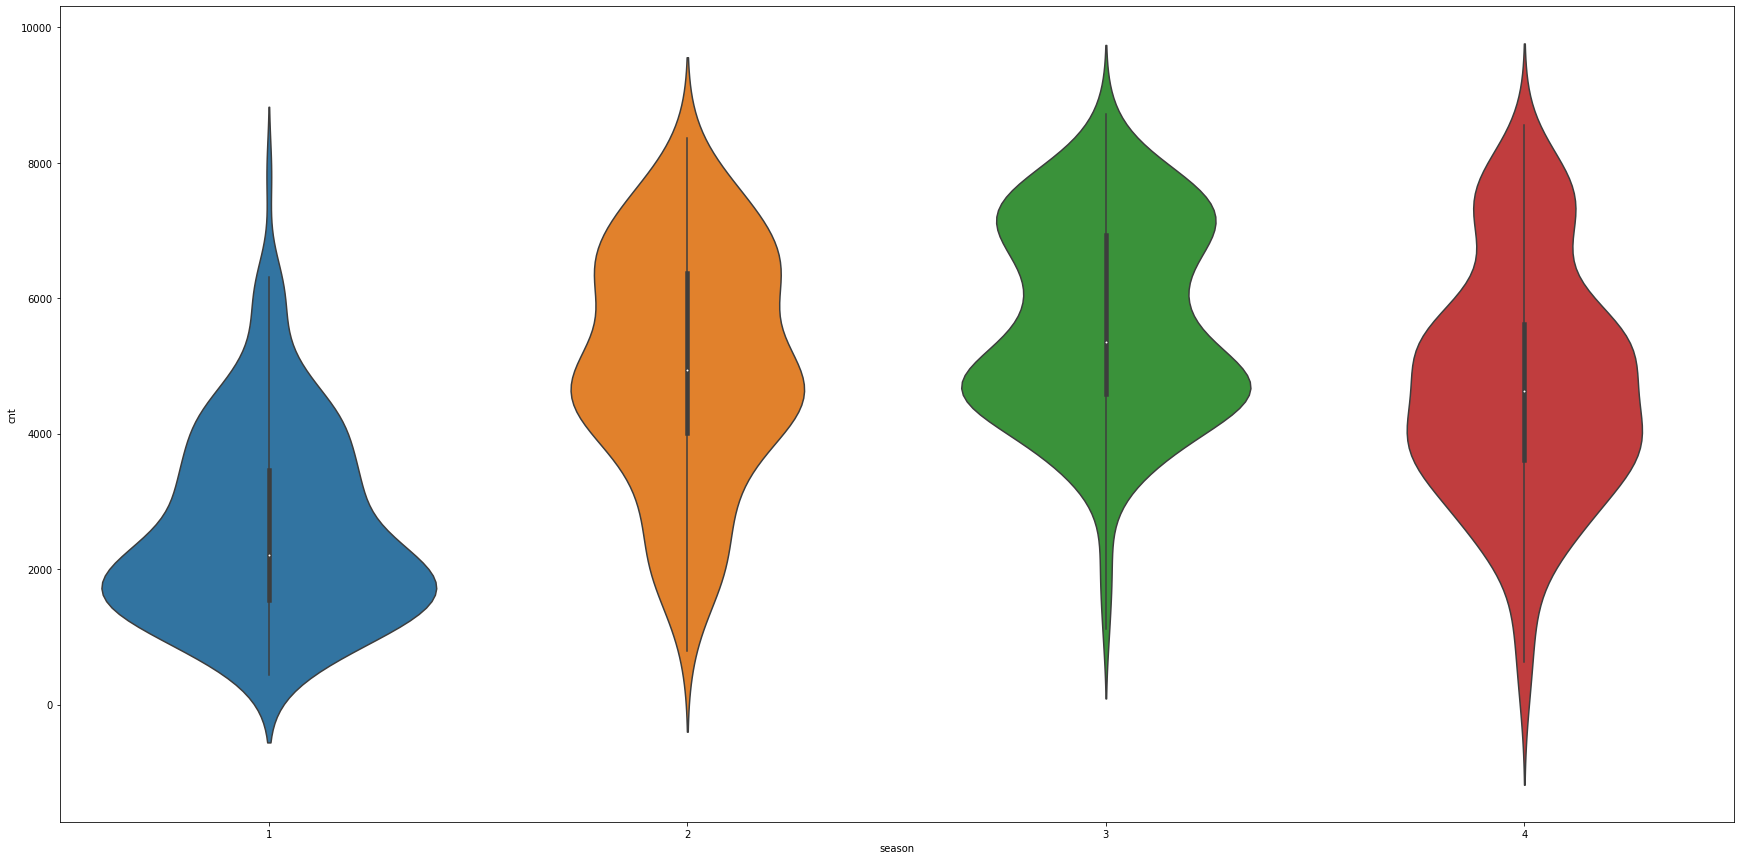

In [25]:
# 季节与骑行数量的关系
# violinplot得到详细分布
fig, ax = plt.subplots(figsize=(30,15))
sns.violinplot(data=data[['season',
                         'cnt']],
             x='season',y='cnt')

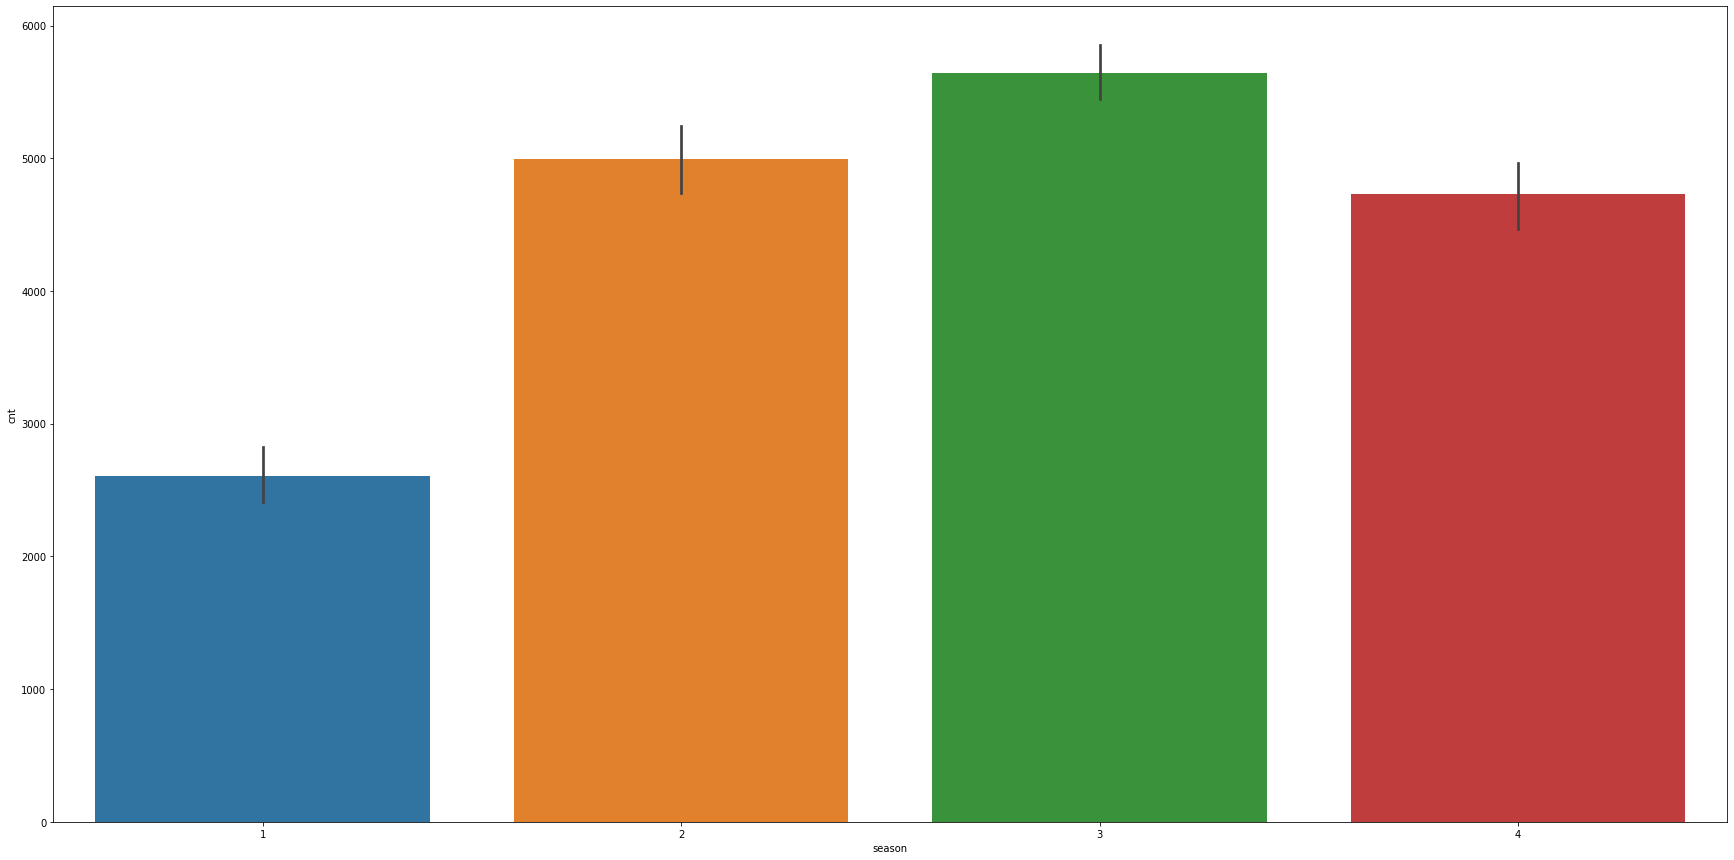

In [26]:
# 季节与骑行数量的关系
fig, ax = plt.subplots(figsize=(30,15))
sns.barplot(data=data[['season',
                         'cnt']],
             x='season',y='cnt')

### 每月骑行量的分布

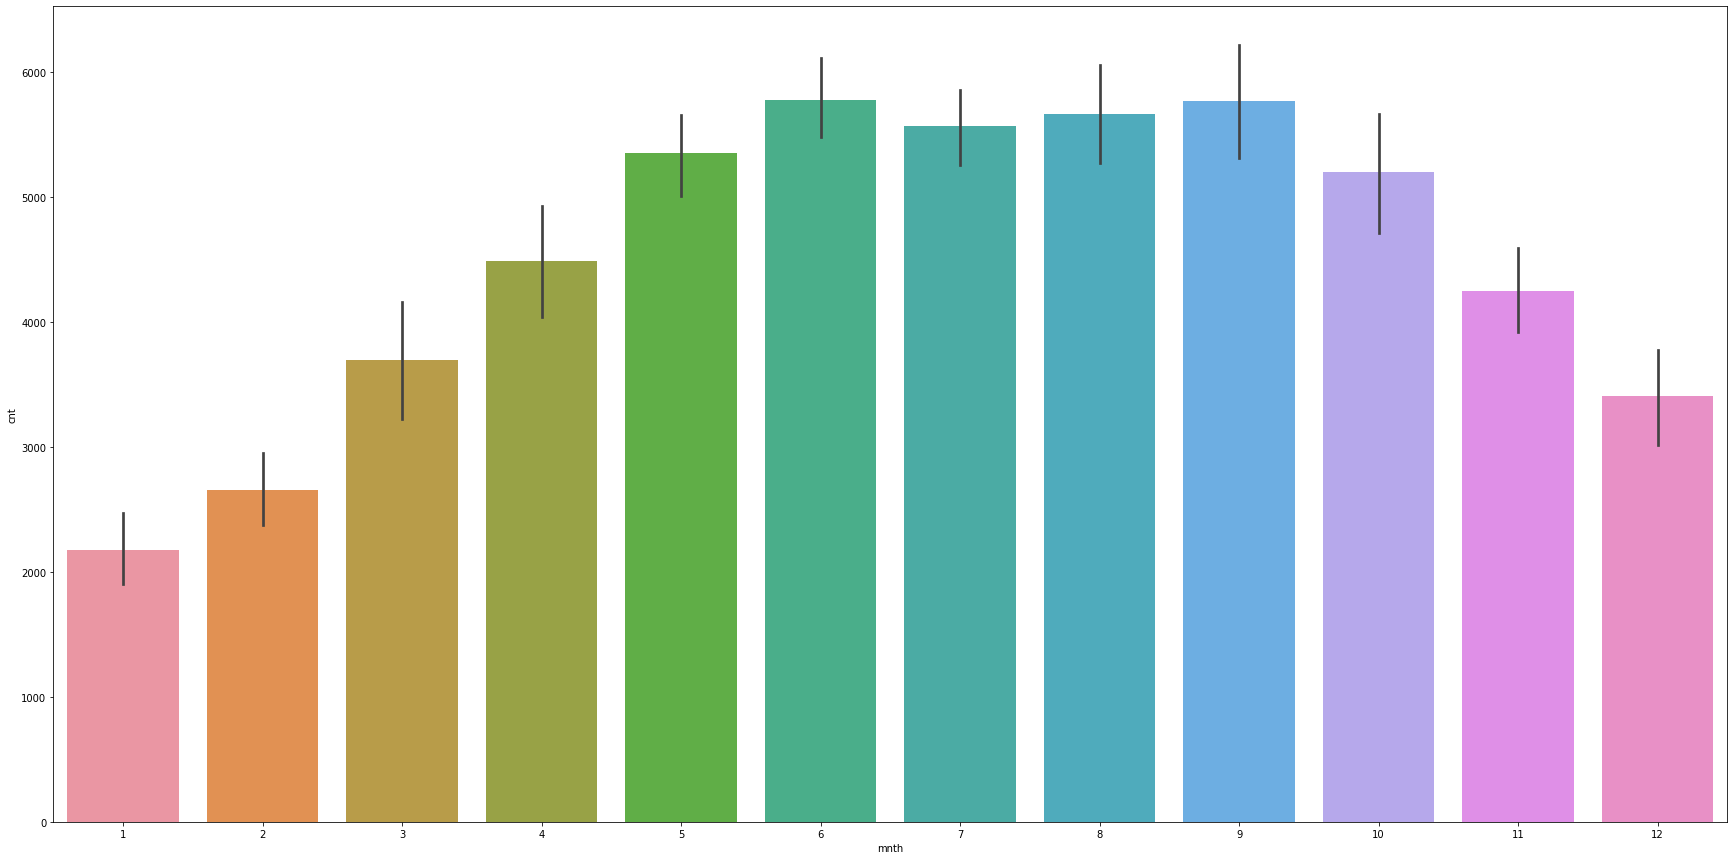

In [27]:
# 月份与骑行数量的关系
fig, ax = plt.subplots(figsize=(30,15))
sns.barplot(data=data[['mnth',
                         'cnt']],
             x='mnth',y='cnt')

骑行量开始和结束月份比较少，中间月份比较多，所以骑行量与月份关系明显

### 每天骑行量的分布

[Text(0.5, 1.0, 'dayly distribution of counts')]

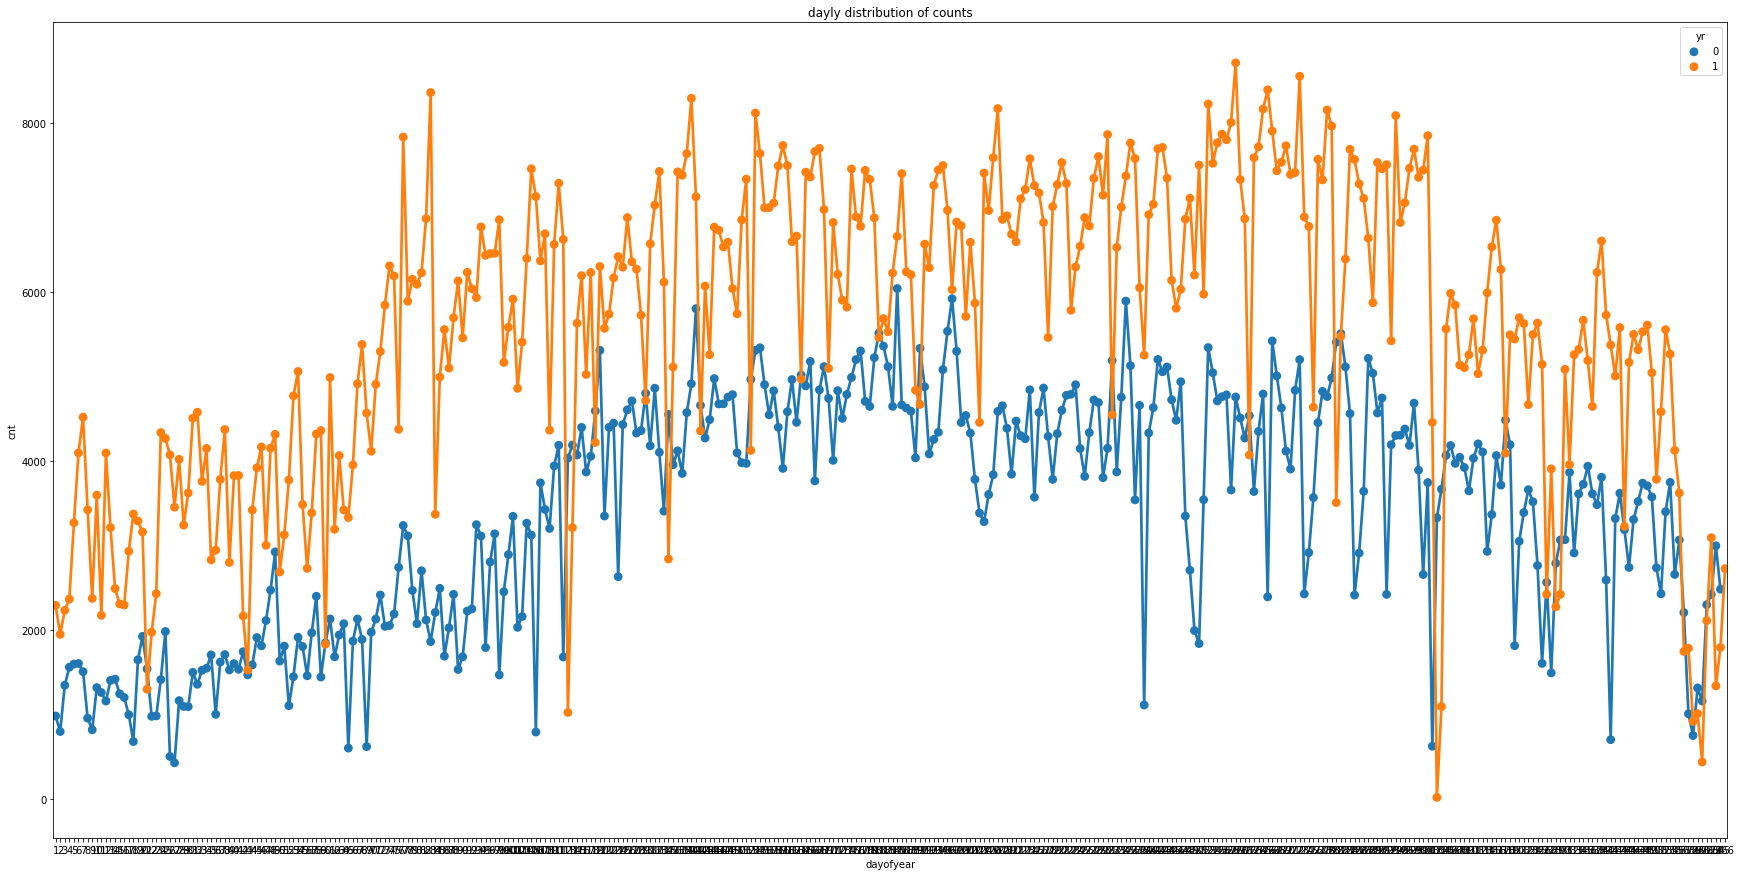

In [28]:
# 一年中每天的骑行量
# 用颜色参数hue表示类别（年）信息
data['date']=pd.to_datetime(data['dteday'])
data['dayofyear']=data['date'].dt.dayofyear # 今年的第几天

fig,ax = plt.subplots(figsize=(30.,15))
sns.pointplot(data=data[['dayofyear','cnt','yr']],x='dayofyear',y='cnt',hue='yr',ax=ax)
ax.set(title='dayly distribution of counts')

2012年每天的骑行量都比2011年有了很大的增长

### 天气与骑行数量的关系

[Text(0.5, 1.0, 'Weathersit distribution of counts')]

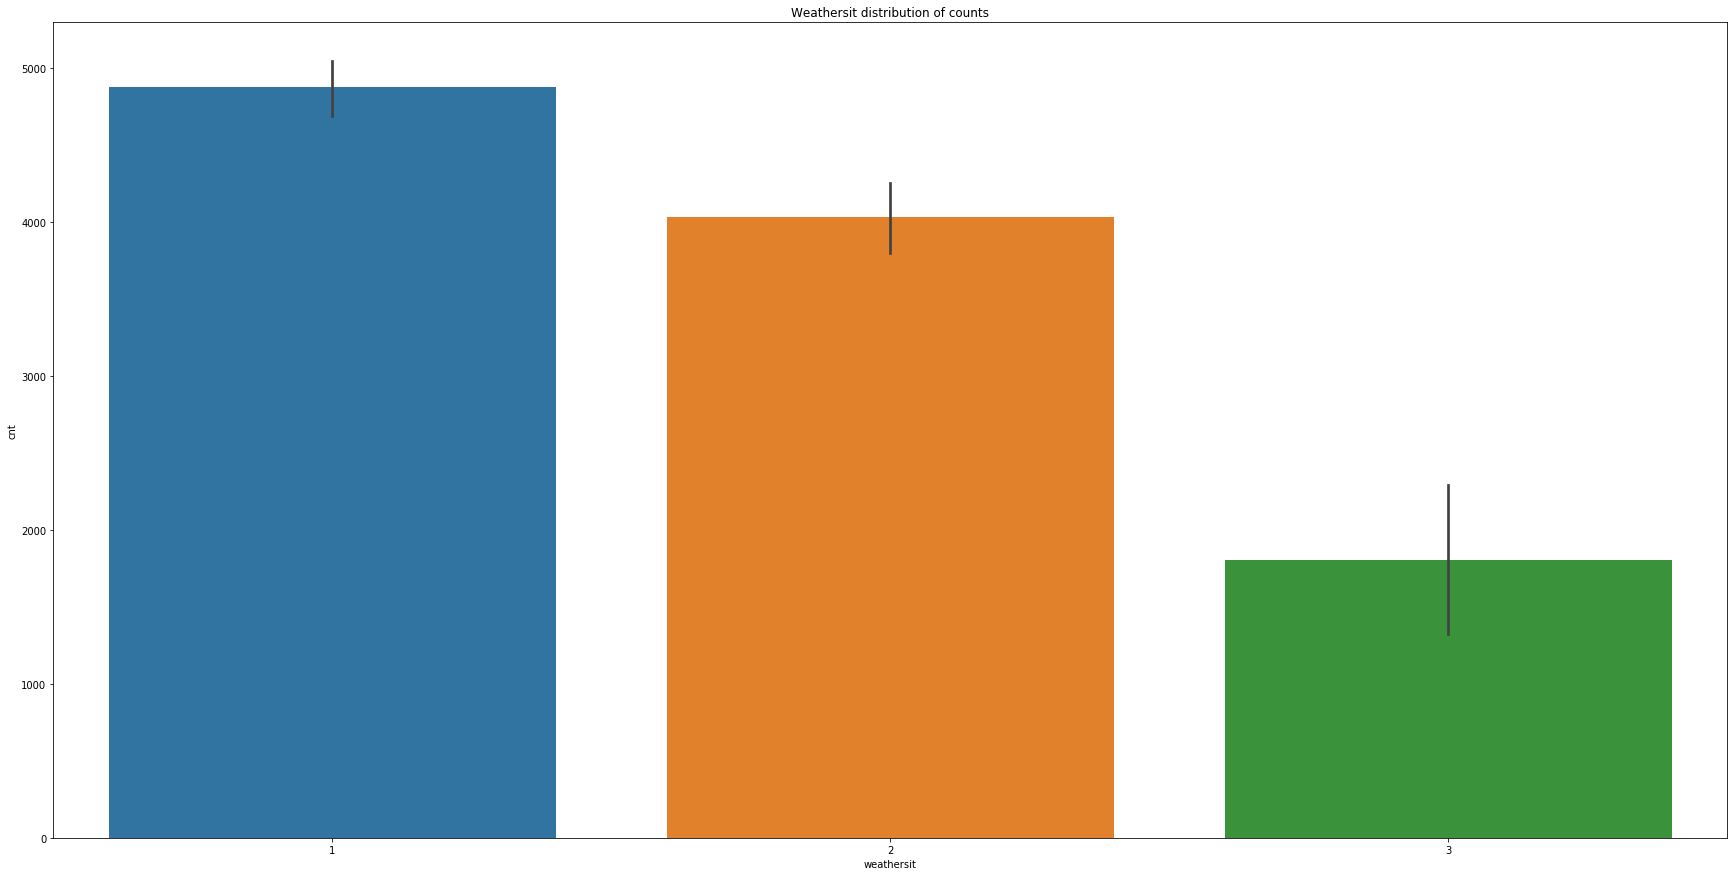

In [29]:
fig, ax = plt.subplots(figsize=(30,15))
sns.barplot(data=data[['weathersit',
                      'cnt']],
          x='weathersit',y='cnt')
ax.set(title='Weathersit distribution of counts')

### 工作日和节假日与骑行量分布

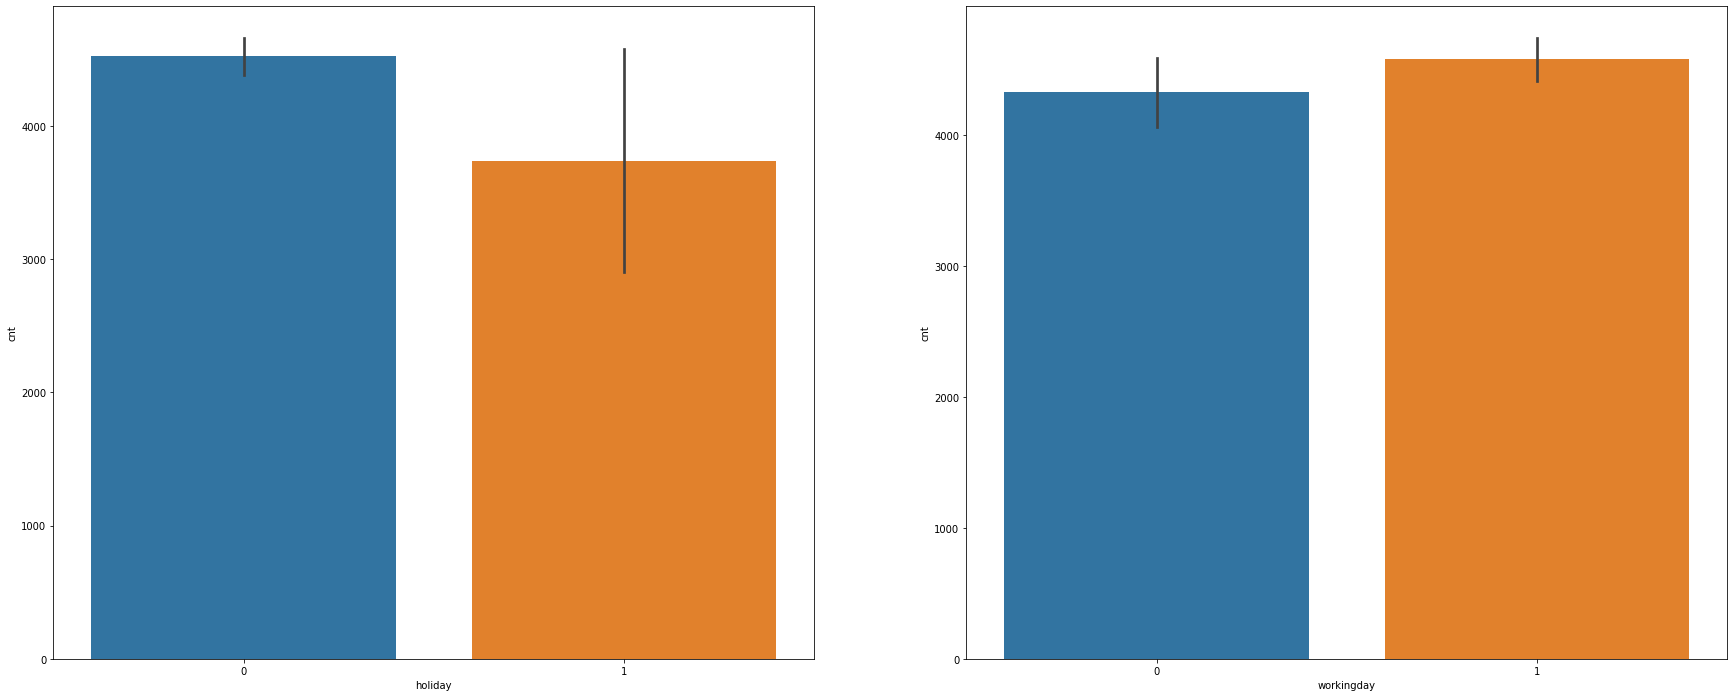

In [33]:
fig, (ax1, ax2) = plt.subplots(figsize=(30,12), ncols=2)
sns.barplot(data=data[['holiday','cnt']], x = 'holiday', y='cnt',ax=ax1)
sns.barplot(data=data,x='workingday',y='cnt',ax=ax2)

##  特征和目标之间的相关性

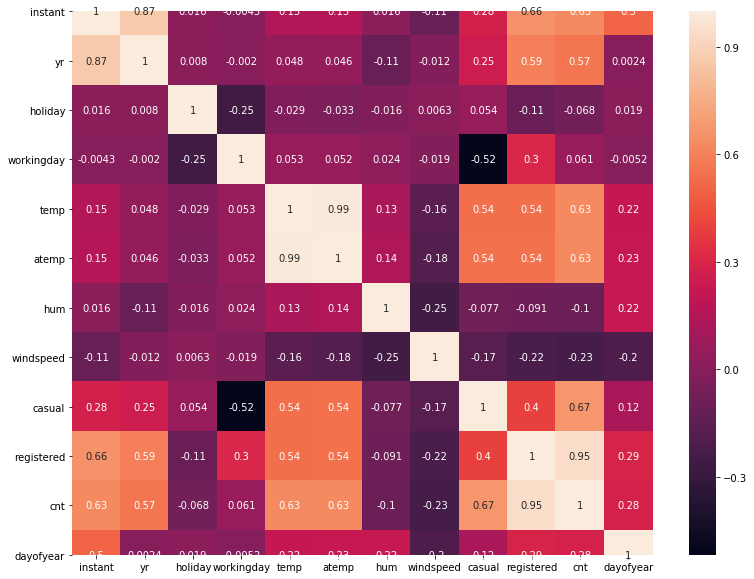

In [36]:
fig=plt.figure(figsize=(13,10))
data_corr=data.corr()
sns.heatmap(data_corr,annot=True) # 用热力图讲相关性呈现出来
plt.show()